In [1]:
# Boring Stuffs, JK It's Important, Download Dataset

import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
# Install Non-Built-In Packages

!pip install mne --quiet

     |████████████████████████████████| 7.5 MB 14.2 MB/s 


In [3]:
# Import Stuffs (Packages)

import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

import mne
from mne import create_info, EpochsArray
from mne.io import RawArray
from mne.baseline import rescale
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet, tfr_array_morlet)
from mne.viz import centers_to_edges

from matplotlib import rcParams
from matplotlib import pyplot as plt

In [4]:
# Load Dataset

alldat = np.load(fname, allow_pickle=True)['dat']

In [ ]:
# Get ROI Electrodes (Post Central & Precentral Gyrus)

electrode_roi = []

# Iterate for Each Subject
for subject_index, subject in enumerate(alldat):

  electrode_indexes_precentral = []
  electrode_indexes_postcentral = []

  for gyrus_index, gyrus in enumerate(subject[0]['gyrus']):
    if gyrus == 'Precentral Gyrus':
      electrode_indexes_precentral.append(gyrus_index)
    elif gyrus == 'Postcentral Gyrus':
      electrode_indexes_postcentral.append(gyrus_index)

  electrode_roi.append(electrode_indexes_precentral + electrode_indexes_postcentral)

  print("""Subject {}:\n  Precentral Gyrus: {}\n  Postcentral Gyrus: {}""".format(subject_index, electrode_indexes_precentral,electrode_indexes_postcentral))

In [10]:
# Data Prep Stuffs

# TODO: Data Preprocessing Needs to Be Refined

# Number of Subjects
subject_count = alldat.shape[0]

# Instantiate Empty Array for All Subjects's Tongue & Hand Epochs
tongue_epochs_real = []
tongue_epochs_imagery = [] 
hand_epochs_real = []
hand_epochs_imagery = []

# Iterate for Each Subject
for subject in alldat:

  # Iterate for Each Test Block (Real & Imagery)
  for index, block in enumerate(subject):

    # Get Timepoints Count, Channel Counts, Sampling Rate & (Total) Stimulus Counts
    time_samples, channels = block['V'].shape
    sampling_freq = block['srate']
    n_stimulus = len(block['t_on'])

    # Generate MNE Info Object Based on Previous Code (Unused for Now)
    block_info = create_info(ch_names=channels, sfreq=sampling_freq, ch_types='ecog')

    # Extract Continuous Voltage Data & Assign Proper Type
    volt_data = block['V'].astype('float32')

    # Multiply with Scale to Calculate uV Values
    # volt_data = volt_data * block['scale_uv']

    # 3rd Order Butterworth Filter (High-pass 1Hz)
    b, a = signal.butter(3, [1], btype='high', fs=1000)
    volt_data = signal.filtfilt(b, a, volt_data, 0)

    # 3rd Order Butterworth Filter (Low-pass 200Hz)
    b, a = signal.butter(3, [200], btype='low', fs=1000)
    volt_data = signal.filtfilt(b, a, volt_data, 0)
    # print(volt_data)

    # Normalize Voltage Data
    # volt_data = volt_data/volt_data.mean(0)

    # Extract {window} ms after Stimulus Onset for All Stimulus (~60 Total), Creating Epochs-Array
    window = 2000
    epoch_window = np.arange(0, window)
    epoch_timepoints = block['t_on'][:, np.newaxis] + epoch_window

    # Transpose Data to Match NME Epochs Object Input Dimension (Credits to Xianhui)
    V_epochs_combined = volt_data[epoch_timepoints, :].transpose((0,2,1))

    # Separate Epochs Between Tongue & Hand
    V_epochs_tongue = (V_epochs_combined[block['stim_id'] == 11, :, :])
    V_epochs_hand = (V_epochs_combined[block['stim_id'] == 12, :, :])
    print(V_epochs_hand)

    # Generate MNE Epochs Object & Append to All Subjects Tongue & Hand Epochs Array
    if index == 0:
      tongue_epochs_real.append(mne.EpochsArray(data=V_epochs_tongue, info=block_info, verbose='WARNING'))
      hand_epochs_real.append(mne.EpochsArray(data=V_epochs_hand, info=block_info, verbose='WARNING'))
    else:
      tongue_epochs_imagery.append(mne.EpochsArray(data=V_epochs_tongue, info=block_info, verbose='WARNING'))
      hand_epochs_imagery.append(mne.EpochsArray(data=V_epochs_hand, info=block_info, verbose='WARNING'))
          

In [14]:
tongue_epochs_real[0]

Number of events,30
Events,1: 30
Time range,0.000 – 1.999 sec
Baseline,off


In [ ]:
# Plot Epochs-Averaged ERP

tongue = tongue_epochs_real[0].average()
tongue.plot();

No baseline correction applied
No baseline correction applied
No baseline correction applied


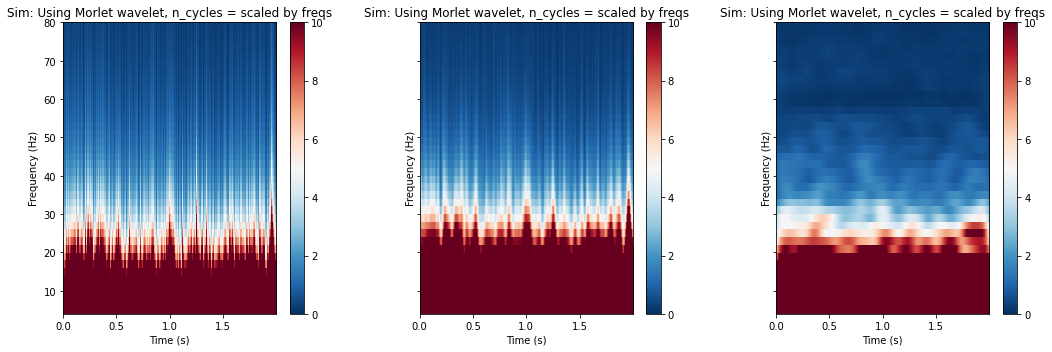

In [16]:
# Time-Frequency Decomposition Using Morlet Wavelet

# TODO: This Is Just Preliminary Stuffs, Further Study on Its Parameters & Preprocessing Required

freqs = np.arange(5., 80., 2.)
vmin, vmax = 0, 10.  # Define our color limits.

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
all_n_cycles = [1, 3, freqs / 2.]
for n_cycles, ax in zip(all_n_cycles, axs):
    power = tfr_morlet(tongue_epochs_real[0], freqs=freqs,
                       n_cycles=n_cycles, return_itc=False, picks=20)
    power.plot([0], mode='mean', vmin=vmin, vmax=vmax,
               axes=ax, show=False, colorbar=True)
    n_cycles = 'scaled by freqs'
    ax.set_title('Sim: Using Morlet wavelet, n_cycles = %s' % n_cycles)
plt.tight_layout()

No baseline correction applied
No baseline correction applied
No baseline correction applied


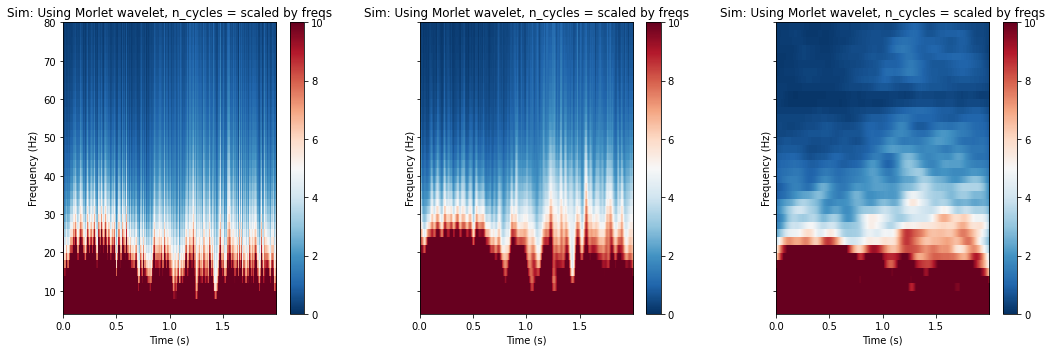

In [17]:
# Time-Frequency Decomposition Using Morlet Wavelet

# TODO: This Is Just Preliminary Stuffs, Further Study on Its Parameters & Preprocessing Required

freqs = np.arange(5., 80., 2.)
vmin, vmax = 0., 10.  # Define our color limits.

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
all_n_cycles = [1, 3, freqs / 2.]
for n_cycles, ax in zip(all_n_cycles, axs):
    power = tfr_morlet(hand_epochs_real[0], freqs=freqs,
                       n_cycles=n_cycles, return_itc=False, picks=20)
    power.plot([0], mode='mean', vmin=vmin, vmax=vmax,
               axes=ax, show=False, colorbar=True)
    n_cycles = 'scaled by freqs'
    ax.set_title('Sim: Using Morlet wavelet, n_cycles = %s' % n_cycles)
plt.tight_layout()

In [ ]:
#@title Deprecated Codes

# Plot ROI Channels (Deprecated)

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

for subject, _ in enumerate(tongue_epochs_real):
  
  roi_channels = electrode_postcentral[subject] + electrode_precentral[subject]

  V_tongue = tongue_epochs_real[subject].mean(0)
  V_hand = hand_epochs_real[subject].mean(0)

  print("Subject {}".format(subject))
  plt.figure(figsize=(20, 10))
  for index, channel in enumerate(roi_channels):
    ax = plt.subplot(5, 6, index+1)
    plt.plot(epoch_window, V_tongue[channel, :])
    plt.plot(epoch_window, V_hand[channel, :])
    plt.title('ch%d'%channel)
    plt.xticks([0, 1000, 2000])
    plt.ylim([0, 4])
  plt.show()